In [5]:
%%python -c "import monai" 
%pip install -q "monai-weekly[nibabel]"
%%python -c "import matplotlib" 
%pip install -q matplotlib
%matplotlib inline

In [6]:

import os
import json
import shutil
import tempfile
import time

import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib

from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai import transforms
from monai.transforms import (
    AsDiscrete,
    Activations,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.utils.enums import MetricReduction
from monai.networks.nets import SwinUNETR
from monai import data
from monai.data import decollate_batch
from functools import partial

import torch


print_config()

MONAI version: 1.3.0
Numpy version: 1.24.3
Pytorch version: 2.1.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 865972f7a791bf7b42efbcd87c8402bd865b329e
MONAI __file__: /Users/<username>/miniconda3/envs/game/lib/python3.8/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.1.0
scikit-image version: 0.19.3
scipy version: 1.10.1
Pillow version: 9.4.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.16.0
tqdm version: 4.65.0
lmdb version: 1.4.1
psutil version: 5.9.0
pandas version: 2.0.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: 4.32.1
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: 1.0.0
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, ple

In [7]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/var/folders/fl/h155blp57svd71z7v5048v500000gn/T/tmpb2oznomt


In [8]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = np.where(self.count > 0, self.sum / self.count, self.sum)


def datafold_read(datalist, basedir, fold=0, key="training"):
    with open(datalist) as f:
        json_data = json.load(f)

    json_data = json_data[key]

    for d in json_data:
        for k in d:
            if isinstance(d[k], list):
                d[k] = [os.path.join(basedir, iv) for iv in d[k]]
            elif isinstance(d[k], str):
                d[k] = os.path.join(basedir, d[k]) if len(d[k]) > 0 else d[k]

    tr = []
    val = []
    for d in json_data:
        if "fold" in d and d["fold"] == fold:
            val.append(d)
        else:
            tr.append(d)

    return tr, val


def save_checkpoint(model, epoch, filename="model.pt", best_acc=0, dir_add=root_dir):
    state_dict = model.state_dict()
    save_dict = {"epoch": epoch, "best_acc": best_acc, "state_dict": state_dict}
    filename = os.path.join(dir_add, filename)
    torch.save(save_dict, filename)
    print("Saving checkpoint", filename)

In [9]:
def get_loader(batch_size, data_dir, json_list, fold, roi):
    data_dir = data_dir
    datalist_json = json_list
    train_files, validation_files = datafold_read(datalist=datalist_json, basedir=data_dir, fold=fold)
    train_transform = transforms.Compose(
        [
            transforms.LoadImaged(keys=["image", "label"]),
            transforms.ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
            transforms.CropForegroundd(
                keys=["image", "label"],
                source_key="image",
                k_divisible=[roi[0], roi[1], roi[2]],
            ),
            transforms.RandSpatialCropd(
                keys=["image", "label"],
                roi_size=[roi[0], roi[1], roi[2]],
                random_size=False,
            ),
            transforms.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
            transforms.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
            transforms.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
            transforms.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
            transforms.RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
            transforms.RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
        ]
    )
    val_transform = transforms.Compose(
        [
            transforms.LoadImaged(keys=["image", "label"]),
            transforms.ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
            transforms.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        ]
    )

    train_ds = data.Dataset(data=train_files, transform=train_transform)

    train_loader = data.DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        num_workers=8,
        pin_memory=True,
    )
    val_ds = data.Dataset(data=validation_files, transform=val_transform)
    val_loader = data.DataLoader(
        val_ds,
        batch_size=1,
        shuffle=False,
        num_workers=8,
        pin_memory=True,
    )

    return train_loader, val_loader

In [10]:
data_dir = "/Users/aibotasanatbek/Documents/projects/calcium_scoring/data/raw/annotated_data_bii"
json_list = "./aorta_datalist.json"
roi = (128, 128, 128)
batch_size = 2
sw_batch_size = 4
fold = 1
infer_overlap = 0.5
max_epochs = 100
val_every = 10
train_loader, val_loader = get_loader(batch_size, data_dir, json_list, fold, roi)

/Users/aibotasanatbek/miniconda3/envs/game/lib/python3.8/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


image shape: (512, 512, 47), label shape: (512, 512, 47)


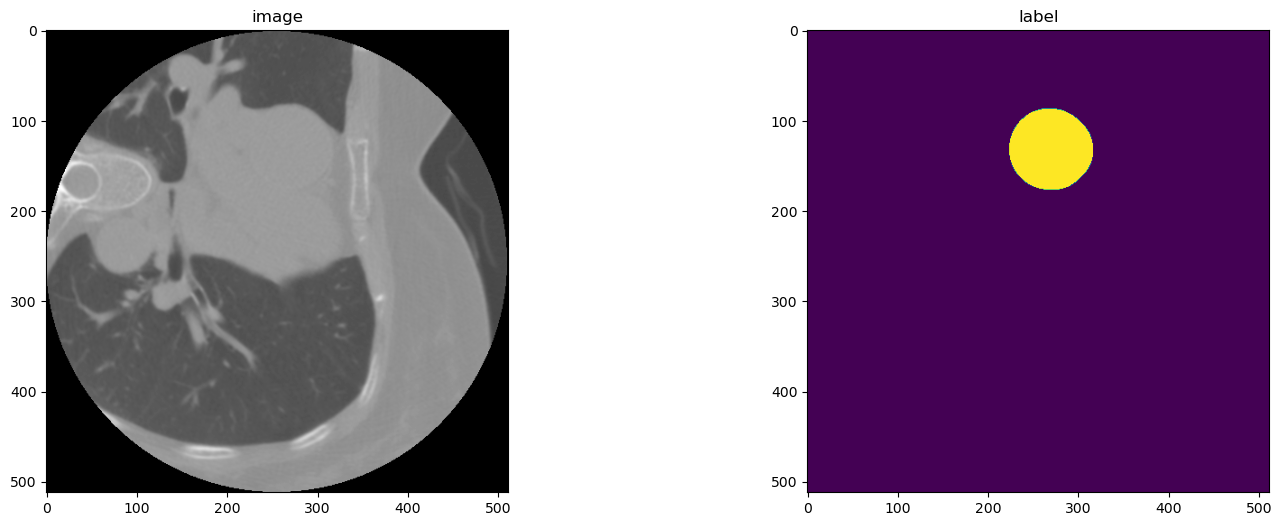

In [13]:
img_add = os.path.join(data_dir, "PD002/og_ct.nii")
label_add = os.path.join(data_dir, "PD002/aorta_mask.nii")
img = nib.load(img_add).get_fdata()
label = nib.load(label_add).get_fdata()
print(f"image shape: {img.shape}, label shape: {label.shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img[:, :, 40], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 40])
plt.show()

In [18]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SwinUNETR(
    img_size=roi,
    in_channels=2,
    out_channels=1,
    feature_size=48,
    drop_rate=0.0,
    attn_drop_rate=0.0,
    dropout_path_rate=0.0,
    use_checkpoint=True,
).to(device)

In [19]:
torch.backends.cudnn.benchmark = True
dice_loss = DiceLoss(to_onehot_y=False, sigmoid=True)
post_sigmoid = Activations(sigmoid=True)
post_pred = AsDiscrete(argmax=False, threshold=0.5)
dice_acc = DiceMetric(include_background=True, reduction=MetricReduction.MEAN_BATCH, get_not_nans=True)
model_inferer = partial(
    sliding_window_inference,
    roi_size=[roi[0], roi[1], roi[2]],
    sw_batch_size=sw_batch_size,
    predictor=model,
    overlap=infer_overlap,
)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

In [20]:
def train_epoch(model, loader, optimizer, epoch, loss_func):
    model.train()
    start_time = time.time()
    run_loss = AverageMeter()
    for idx, batch_data in enumerate(loader):
        data, target = batch_data["image"].to(device), batch_data["label"].to(device)
        logits = model(data)
        loss = loss_func(logits, target)
        loss.backward()
        optimizer.step()
        run_loss.update(loss.item(), n=batch_size)
        print(
            "Epoch {}/{} {}/{}".format(epoch, max_epochs, idx, len(loader)),
            "loss: {:.4f}".format(run_loss.avg),
            "time {:.2f}s".format(time.time() - start_time),
        )
        start_time = time.time()
    return run_loss.avg


def val_epoch(
    model,
    loader,
    epoch,
    acc_func,
    model_inferer=None,
    post_sigmoid=None,
    post_pred=None,
):
    model.eval()
    start_time = time.time()
    run_acc = AverageMeter()

    with torch.no_grad():
        for idx, batch_data in enumerate(loader):
            data, target = batch_data["image"].to(device), batch_data["label"].to(device)
            logits = model_inferer(data)
            val_labels_list = decollate_batch(target)
            val_outputs_list = decollate_batch(logits)
            val_output_convert = [post_pred(post_sigmoid(val_pred_tensor)) for val_pred_tensor in val_outputs_list]
            acc_func.reset()
            acc_func(y_pred=val_output_convert, y=val_labels_list)
            acc, not_nans = acc_func.aggregate()
            run_acc.update(acc.cpu().numpy(), n=not_nans.cpu().numpy())
            dice_tc = run_acc.avg[0]
            dice_wt = run_acc.avg[1]
            dice_et = run_acc.avg[2]
            print(
                "Val {}/{} {}/{}".format(epoch, max_epochs, idx, len(loader)),
                ", dice_tc:",
                dice_tc,
                ", dice_wt:",
                dice_wt,
                ", dice_et:",
                dice_et,
                ", time {:.2f}s".format(time.time() - start_time),
            )
            start_time = time.time()

    return run_acc.avg

In [21]:
def trainer(
    model,
    train_loader,
    val_loader,
    optimizer,
    loss_func,
    acc_func,
    scheduler,
    model_inferer=None,
    start_epoch=0,
    post_sigmoid=None,
    post_pred=None,
):
    val_acc_max = 0.0
    dices_tc = []
    dices_wt = []
    dices_et = []
    dices_avg = []
    loss_epochs = []
    trains_epoch = []
    for epoch in range(start_epoch, max_epochs):
        print(time.ctime(), "Epoch:", epoch)
        epoch_time = time.time()
        train_loss = train_epoch(
            model,
            train_loader,
            optimizer,
            epoch=epoch,
            loss_func=loss_func,
        )
        print(
            "Final training  {}/{}".format(epoch, max_epochs - 1),
            "loss: {:.4f}".format(train_loss),
            "time {:.2f}s".format(time.time() - epoch_time),
        )

        if (epoch + 1) % val_every == 0 or epoch == 0:
            loss_epochs.append(train_loss)
            trains_epoch.append(int(epoch))
            epoch_time = time.time()
            val_acc = val_epoch(
                model,
                val_loader,
                epoch=epoch,
                acc_func=acc_func,
                model_inferer=model_inferer,
                post_sigmoid=post_sigmoid,
                post_pred=post_pred,
            )
            dice_tc = val_acc[0]
            dice_wt = val_acc[1]
            dice_et = val_acc[2]
            val_avg_acc = np.mean(val_acc)
            print(
                "Final validation stats {}/{}".format(epoch, max_epochs - 1),
                ", dice_tc:",
                dice_tc,
                ", dice_wt:",
                dice_wt,
                ", dice_et:",
                dice_et,
                ", Dice_Avg:",
                val_avg_acc,
                ", time {:.2f}s".format(time.time() - epoch_time),
            )
            dices_tc.append(dice_tc)
            dices_wt.append(dice_wt)
            dices_et.append(dice_et)
            dices_avg.append(val_avg_acc)
            if val_avg_acc > val_acc_max:
                print("new best ({:.6f} --> {:.6f}). ".format(val_acc_max, val_avg_acc))
                val_acc_max = val_avg_acc
                save_checkpoint(
                    model,
                    epoch,
                    best_acc=val_acc_max,
                )
            scheduler.step()
    print("Training Finished !, Best Accuracy: ", val_acc_max)
    return (
        val_acc_max,
        dices_tc,
        dices_wt,
        dices_et,
        dices_avg,
        loss_epochs,
        trains_epoch,
    )

In [22]:
start_epoch = 0

(
    val_acc_max,
    dices_tc,
    dices_wt,
    dices_et,
    dices_avg,
    loss_epochs,
    trains_epoch,
) = trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    loss_func=dice_loss,
    acc_func=dice_acc,
    scheduler=scheduler,
    model_inferer=model_inferer,
    start_epoch=start_epoch,
    post_sigmoid=post_sigmoid,
    post_pred=post_pred,
)

print(f"train completed, best average dice: {val_acc_max:.4f} ")

Mon Dec  4 21:40:59 2023 Epoch: 0


RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/Users/aibotasanatbek/miniconda3/envs/game/lib/python3.8/site-packages/nibabel/loadsave.py", line 100, in load
    stat_result = os.stat(filename)
FileNotFoundError: [Errno 2] No such file or directory: '/Users/aibotasanatbek/Documents/projects/calcium_scoring/data/raw/annotated_data_bii/PD124/og_ct.nii'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/aibotasanatbek/miniconda3/envs/game/lib/python3.8/site-packages/monai/transforms/transform.py", line 141, in apply_transform
    return _apply_transform(transform, data, unpack_items, lazy, overrides, log_stats)
  File "/Users/aibotasanatbek/miniconda3/envs/game/lib/python3.8/site-packages/monai/transforms/transform.py", line 98, in _apply_transform
    return transform(data, lazy=lazy) if isinstance(transform, LazyTrait) else transform(data)
  File "/Users/aibotasanatbek/miniconda3/envs/game/lib/python3.8/site-packages/monai/transforms/io/dictionary.py", line 162, in __call__
    data = self._loader(d[key], reader)
  File "/Users/aibotasanatbek/miniconda3/envs/game/lib/python3.8/site-packages/monai/transforms/io/array.py", line 255, in __call__
    img = reader.read(filename)
  File "/Users/aibotasanatbek/miniconda3/envs/game/lib/python3.8/site-packages/monai/data/image_reader.py", line 908, in read
    img = nib.load(name, **kwargs_)
  File "/Users/aibotasanatbek/miniconda3/envs/game/lib/python3.8/site-packages/nibabel/loadsave.py", line 102, in load
    raise FileNotFoundError(f"No such file or no access: '{filename}'")
FileNotFoundError: No such file or no access: '/Users/aibotasanatbek/Documents/projects/calcium_scoring/data/raw/annotated_data_bii/PD124/og_ct.nii'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/aibotasanatbek/miniconda3/envs/game/lib/python3.8/site-packages/monai/transforms/transform.py", line 141, in apply_transform
    return _apply_transform(transform, data, unpack_items, lazy, overrides, log_stats)
  File "/Users/aibotasanatbek/miniconda3/envs/game/lib/python3.8/site-packages/monai/transforms/transform.py", line 98, in _apply_transform
    return transform(data, lazy=lazy) if isinstance(transform, LazyTrait) else transform(data)
  File "/Users/aibotasanatbek/miniconda3/envs/game/lib/python3.8/site-packages/monai/transforms/compose.py", line 335, in __call__
    result = execute_compose(
  File "/Users/aibotasanatbek/miniconda3/envs/game/lib/python3.8/site-packages/monai/transforms/compose.py", line 111, in execute_compose
    data = apply_transform(
  File "/Users/aibotasanatbek/miniconda3/envs/game/lib/python3.8/site-packages/monai/transforms/transform.py", line 171, in apply_transform
    raise RuntimeError(f"applying transform {transform}") from e
RuntimeError: applying transform <monai.transforms.io.dictionary.LoadImaged object at 0x100d51910>

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/aibotasanatbek/miniconda3/envs/game/lib/python3.8/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "/Users/aibotasanatbek/miniconda3/envs/game/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/Users/aibotasanatbek/miniconda3/envs/game/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/Users/aibotasanatbek/miniconda3/envs/game/lib/python3.8/site-packages/monai/data/dataset.py", line 112, in __getitem__
    return self._transform(index)
  File "/Users/aibotasanatbek/miniconda3/envs/game/lib/python3.8/site-packages/monai/data/dataset.py", line 98, in _transform
    return apply_transform(self.transform, data_i) if self.transform is not None else data_i
  File "/Users/aibotasanatbek/miniconda3/envs/game/lib/python3.8/site-packages/monai/transforms/transform.py", line 171, in apply_transform
    raise RuntimeError(f"applying transform {transform}") from e
RuntimeError: applying transform <monai.transforms.compose.Compose object at 0x100d51fd0>


NameError: name 'trains_epoch' is not defined

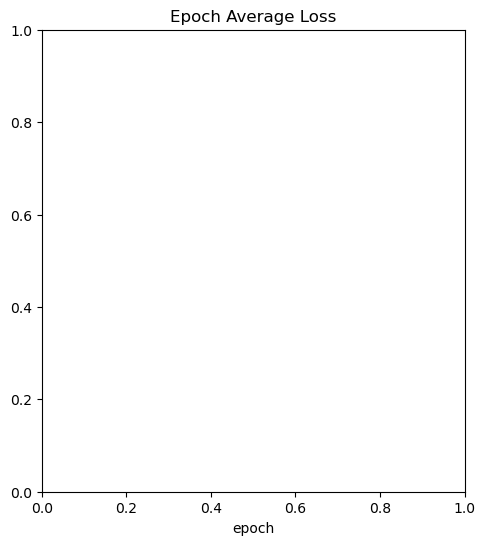

In [23]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
plt.xlabel("epoch")
plt.plot(trains_epoch, loss_epochs, color="red")
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
plt.xlabel("epoch")
plt.plot(trains_epoch, dices_avg, color="green")
plt.show()
plt.figure("train", (18, 6))
plt.subplot(1, 3, 1)
plt.title("Val Mean Dice TC")
plt.xlabel("epoch")
plt.plot(trains_epoch, dices_tc, color="blue")
plt.subplot(1, 3, 2)
plt.title("Val Mean Dice WT")
plt.xlabel("epoch")
plt.plot(trains_epoch, dices_wt, color="brown")
plt.subplot(1, 3, 3)
plt.title("Val Mean Dice ET")
plt.xlabel("epoch")
plt.plot(trains_epoch, dices_et, color="purple")
plt.show()

In [24]:
case_num = "01619"

test_files = [
    {
        "image": [
            os.path.join(data_dir, "PD275/og_ct.nii"),
            os.path.join(data_dir, "PD198/og_ct.nii"),
            os.path.join(data_dir, "PD176/og_ct.nii"),
            os.path.join(data_dir, "PD101/og_ct.nii"),
            os.path.join(data_dir, "PD095/og_ct.nii"),
            os.path.join(data_dir, "PD192/og_ct.nii"),
            os.path.join(data_dir, "PD006/og_ct.nii"),
            os.path.join(data_dir, "PD071/og_ct.nii"),
            os.path.join(data_dir, "PD254/og_ct.nii"),
            os.path.join(data_dir, "PD223/og_ct.nii"),

        ],
        "label": [
            os.path.join(data_dir, "PD275/aorta_mask.nii"),
            os.path.join(data_dir, "PD198/aorta_mask.nii"),
            os.path.join(data_dir, "PD176/aorta_mask.nii"),
            os.path.join(data_dir, "PD101/aorta_mask.nii"),
            os.path.join(data_dir, "PD095/aorta_mask.nii"),
            os.path.join(data_dir, "PD192/aorta_mask.nii"),
            os.path.join(data_dir, "PD006/aorta_mask.nii"),
            os.path.join(data_dir, "PD071/aorta_mask.nii"),
            os.path.join(data_dir, "PD254/aorta_mask.nii"),
            os.path.join(data_dir, "PD223/aorta_mask.nii"),
        ]
    }
]

test_transform = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image", "label"]),
        transforms.ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        transforms.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)

test_ds = data.Dataset(data=test_files, transform=test_transform)

test_loader = data.DataLoader(
    test_ds,
    batch_size=1,
    shuffle=False,
    num_workers=8,
    pin_memory=True,
)

In [25]:
model.load_state_dict(torch.load(os.path.join(root_dir, "model.pt"))["state_dict"])
model.to(device)
model.eval()

model_inferer_test = partial(
    sliding_window_inference,
    roi_size=[roi[0], roi[1], roi[2]],
    sw_batch_size=1,
    predictor=model,
    overlap=0.6,
)


with torch.no_grad():
    for batch_data in test_loader:
        image = batch_data["image"].cuda()
        prob = torch.sigmoid(model_inferer_test(image))
        seg = prob[0].detach().cpu().numpy()
        seg = (seg > 0.5).astype(np.int8)
        seg_out = np.zeros((seg.shape[1], seg.shape[2], seg.shape[3]))
        seg_out[seg[1] == 1] = 2
        seg_out[seg[0] == 1] = 1
        seg_out[seg[2] == 1] = 4

FileNotFoundError: [Errno 2] No such file or directory: '/var/folders/fl/h155blp57svd71z7v5048v500000gn/T/tmpb2oznomt/model.pt'

## Visualize segmentation output and compare with label

In [26]:
slice_num = 67
img_add = os.path.join(
    data_dir,
    "TrainingData/BraTS2021_" + case_num + "/BraTS2021_" + case_num + "_t1ce.nii.gz",
)
label_add = os.path.join(
    data_dir,
    "TrainingData/BraTS2021_" + case_num + "/BraTS2021_" + case_num + "_seg.nii.gz",
)
img = nib.load(img_add).get_fdata()
label = nib.load(label_add).get_fdata()
plt.figure("image", (18, 6))
plt.subplot(1, 3, 1)
plt.title("image")
plt.imshow(img[:, :, slice_num], cmap="gray")
plt.subplot(1, 3, 2)
plt.title("label")
plt.imshow(label[:, :, slice_num])
plt.subplot(1, 3, 3)
plt.title("segmentation")
plt.imshow(seg_out[:, :, slice_num])
plt.show()

FileNotFoundError: No such file or no access: '/Users/aibotasanatbek/Documents/projects/calcium_scoring/data/raw/annotated_data_bii/TrainingData/BraTS2021_01619/BraTS2021_01619_t1ce.nii.gz'